In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import atmosentry
from atmosentry.meteoroid import Meteoroid

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
def gen_impactor(R0, sigma_imp=1e4, rho_imp = 0.6e3):

    # impactor's heat of ablation, bulk density
    eta_imp = 2.5e6 # J/kg

    theta0 = 45. * np.pi / 180. # impact angle (radians)
    V0 = 20e3 # top-of-atmosphere impact velocity

    M0 = rho_imp * (4 * np.pi / 3) * (R0 ** 3) # initial mass

    impactor = Meteoroid(x=0,
                        y=0,
                        z=100e3,
                        vx=-V0 * np.cos(theta0),
                        vy=0,
                        vz=-V0 * np.sin(theta0),
                        radius=R0,
                        mass=M0,
                        sigma=sigma_imp,
                        rho=rho_imp,
                        eta=eta_imp)
    
    return impactor

In [4]:
def calc_combined_fragment_deposition(sim):
    """
    Docstring: need to combine contribution from contributions at constant altitude... (rewrite)
    """
    
    altitudes = np.linspace(0, 100e3, 10000)
    cumulative_energy_deposition = np.zeros_like(altitudes)
    cumulative_mass_deposition = np.zeros_like(altitudes)

    for j, h in enumerate(altitudes):
        cumulative_dE = 0.0
        cumulative_dM = 0.0

        cumulative_dE += np.sum(sim.impactor.state.dEkin[sim.impactor.state.z >= h])
        cumulative_dM += np.sum(sim.impactor.state.dM[sim.impactor.state.z >= h])

        for fragment in sim.fragments:
            cumulative_dE += np.sum(fragment.state.dEkin[fragment.state.z >= h])
            cumulative_dM += np.sum(fragment.state.dM[fragment.state.z >= h])
        
        cumulative_energy_deposition[j] = cumulative_dE
        cumulative_mass_deposition[j] = cumulative_dM
    
    return altitudes, cumulative_energy_deposition, cumulative_mass_deposition

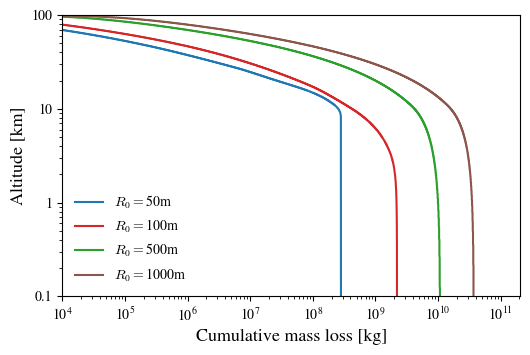

In [4]:
# here we set the tensile strength we want to test
radii = [50, 100, 500, 1000]
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:brown']

_ = plt.figure(figsize=(5.91, 3.65))

for counter, rad in enumerate(radii):

    sim = atmosentry.Simulation()

    impactor = gen_impactor(rad)
    sim.impactor = impactor

    sim.dt = 1e-2 # here you can set the maximum timestep of the simulation

    sim.integrate()

    KE0 = 0.5 * sim.impactor.mass * (20e3 ** 2)

    altitudes, cumulative_energy_deposition, cumulative_mass_deposition = calc_combined_fragment_deposition(sim)

    plt.plot(cumulative_mass_deposition, altitudes / 1e3, c=colors[counter], label=rf'$R_0=${rad}m')

plt.xscale('log') 
plt.yscale('log')

plt.xlim(1e4, )
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Cumulative mass loss [kg]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.legend(frameon=False, loc='lower left')

plt.show()

It is clear above that the altitude of maximum mass deposition is size-dependent. For large comets, mass loss accounts for a very small fraction of the comet's initial mass, whereas small comets lose all their mass at high altitudes. Note, mass loss from large comets is still higher in the upper atmosphere, although total mass deposition will depend on the comets' SFD...

#### uncertainty in the heat of ablation

Here, we demonstrate the sensitivity of mass deposition to the heat of ablation: there is the most uncertainty in this parameters, and this has a large effect on model results.

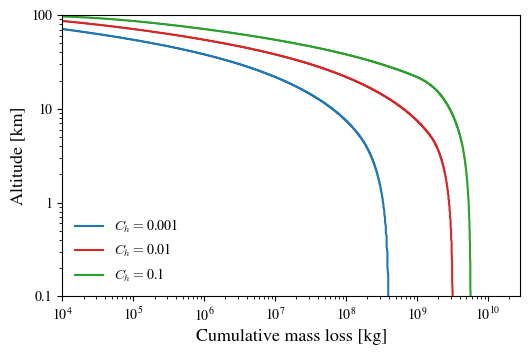

In [7]:
# here we set the tensile strength we want to test
R0 = 250
Chs = [0.001, 0.01, 0.1]
colors = ['tab:blue', 'tab:red', 'tab:green']

_ = plt.figure(figsize=(5.91, 3.65))

for counter, Ch in enumerate(Chs):

    sim = atmosentry.Simulation()

    impactor = gen_impactor(R0)
    sim.impactor = impactor

    sim.dt = 1e-2 # here you can set the maximum timestep of the simulation
    sim.Ch = Ch

    sim.integrate()

    KE0 = 0.5 * sim.impactor.mass * (20e3 ** 2)

    altitudes, cumulative_energy_deposition, cumulative_mass_deposition = calc_combined_fragment_deposition(sim)

    plt.plot(cumulative_mass_deposition, altitudes / 1e3, c=colors[counter], label=rf'$C_h=${Ch}')

plt.xscale('log') 
plt.yscale('log')

plt.xlim(1e4, )
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Cumulative mass loss [kg]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.legend(frameon=False, loc='lower left')

plt.show()

From above, it is clear that this scales, almost exactly, with the value of the heat transfer coefficient. At high altitudes, in the observable upper atmosphere, cumulative mass deposition changes by several orders of magnitude.

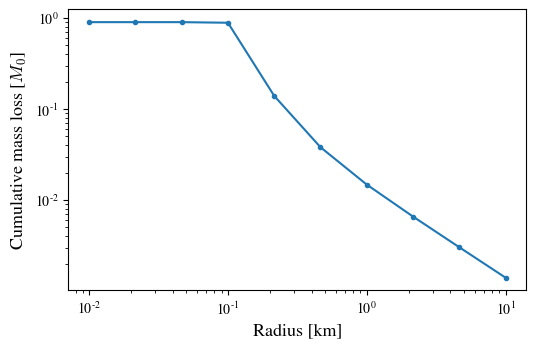

In [12]:
radii = np.logspace(1, 4, 10)

m_deposition = []
for counter, rad in enumerate(radii):

    sim = atmosentry.Simulation()

    impactor = gen_impactor(rad)
    sim.impactor = impactor

    sim.dt = 1e-2 # here you can set the maximum timestep of the simulation

    sim.integrate()

    altitudes, _, cumulative_mass_deposition = calc_combined_fragment_deposition(sim)

    m_deposition = np.append(m_deposition, cumulative_mass_deposition[0] / sim.impactor.mass)

_ = plt.figure(figsize=(5.91, 3.65))

plt.plot(radii / 1e3, m_deposition, marker='.')

plt.xscale('log') 
plt.yscale('log')

plt.xlabel(r'Radius [km]', fontsize=13)
plt.ylabel(r'Cumulative mass loss [$M_0$]', fontsize=13)

plt.minorticks_on()

plt.show()